In [2]:
# Import necessary libraries
import os,re
import pandas as pd
from praatio import tgio
import numpy as np
from tqdm import tqdm
from findwords import find_words
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Set the working directory to the specified path
new_directory = "S:/FADS/ccs_corpus-main/Summer2024/01_Microservices/3_Forced_Alignment"
os.chdir(new_directory)

# Define file paths
input_dir = './Input_Output/Input/ccs_test2'  # Directory containing input TextGrid files
output_dir = './Input_Output/Output/ccs_test2_output'  # Directory containing output TextGrid files

# Get list of input TextGrid files
fls_inputs = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.TextGrid')]
fls_outputs = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.TextGrid')]

# Create dataframes for input files
df_fls_in = pd.DataFrame({'files_in_loc': fls_inputs, 'files': [os.path.basename(f) for f in fls_inputs]})
df_fls_out = pd.DataFrame({'files_out_loc': fls_outputs, 'files': [os.path.basename(f) for f in fls_outputs]})

# Merge the dataframes on the 'files' column
df_fls = pd.merge(df_fls_out, df_fls_in, on='files')

# Display the merged dataframe
df_fls


,files_out_loc,files,files_in_loc
0,./Input_Output/Output/ccs_test2_output\CA1HA_8...,CA1HA_87.TextGrid,./Input_Output/Input/ccs_test2\CA1HA_87.TextGrid


In [4]:
# Initialize an empty DataFrame to store the results
dat = pd.DataFrame()
cntr = 1

# Iterate through each row in the merged dataframe df_fls
for i, row in tqdm(df_fls.iterrows(), total=df_fls.shape[0]):

    # Print the progress
    #print(f"{cntr}/{df_fls.shape[0]}")
    
    # Open the input and output TextGrid files
    tg_input = tgio.openTextgrid(row['files_in_loc'])
    tg_output = tgio.openTextgrid(row['files_out_loc'])
    
    # Extract interval data from the input TextGrid
    data_in = []
    for tierName in tg_input.tierNameList:
        tier = tg_input.tierDict[tierName]
        for interval in tier.entryList:
            start, end, label = interval
            data_in.append([start, end, label])
    
    # Create a DataFrame from the interval data
    df_in = pd.DataFrame(data_in, columns=['Start', 'End', 'Label'])
    
    # Add a new interval tier and insert intervals into the output TextGrid
    new_tier_name = "Text"
    new_tier_entries = []
    for _, rows in df_in.iterrows():
        new_tier_entries.append((rows['Start'], rows['End'], rows['Label']))

    new_tier = tgio.IntervalTier(new_tier_name, new_tier_entries, tg_input.minTimestamp, tg_input.maxTimestamp)
    tg_output.addTier(new_tier)
    
    fullname = os.path.splitext(os.path.basename(row['files']))[0]
    
    tg = tg_output
    tier_names = tg.tierNameList
    
    word_tier = tier_names[0] 
    segment_tier = tier_names[1]
    text_tier = tier_names[2]  
    
    tier = tg.tierDict[segment_tier]
    # Get the labels, onset times (t1), and offset times (t2) from the segment tier
    labels = [entry[2] for entry in tier.entryList]
    onset_times = [entry[0] for entry in tier.entryList]
    offset_times = [entry[1] for entry in tier.entryList]

    # Get indices of labels that are not in the specified list of excluded labels
    exclude_labels = ['', 'sp', 'sil']
    tmp_segs_locs = [i for i, label in enumerate(labels) if label not in exclude_labels]
    
    def str_squish(text):
        return re.sub(r'\s+', ' ', text).strip()
    
    # Select and clean the labels of the segments to keep
    tmp_segs = [tier.entryList[i][2] for i in tmp_segs_locs]
    tmp_segs = [str_squish(label) for label in tmp_segs]
    
    # Get previous and following segment labels
    tmp_segs_prev = [labels[i - 1] for i in tmp_segs_locs if i > 0]
    tmp_segs_prev.insert(0, "")

    tmp_segs_foll = [labels[i + 1] for i in tmp_segs_locs if i < len(labels) - 1]
    tmp_segs_foll.append("")

    # Get the onset and offset times of the segments
    tmp_segs_onset = [onset_times[i] for i in tmp_segs_locs]
    tmp_segs_offset = [offset_times[i] for i in tmp_segs_locs]
    tmp_segs_dur = [offset - onset for onset, offset in zip(tmp_segs_onset, tmp_segs_offset)]

    # Retrieve text and word data for the segments
    text_data = [find_words(tg, loc, segment_tier, text_tier) for loc in tmp_segs_locs]
    word_data = [find_words(tg, loc, segment_tier, word_tier) for loc in tmp_segs_locs]
    
    text_df = pd.DataFrame(text_data, columns=['textlabel', 'textOnset', 'textOffset', 'textMid', 'textDur', 'textLoc'])
    word_df = pd.DataFrame(word_data, columns=['wordlabel', 'wordOnset', 'wordOffset', 'wordMid', 'wordDur', 'wordLoc'])
    
    def get_previous_texts(tg, text_tier_label, df):
        # Access the text tier
        text_tier = tg.tierDict[text_tier_label]
        prev = []
        # Iterate through each row in the DataFrame
        for index, row in df.iterrows():
            text_loc = int(row.iloc[5])  # Convert to integer if necessary
            if text_loc > 0:
                # Get the label of the previous text
                prev_text = text_tier.entryList[text_loc - 1][2]
            else:
                prev_text = ""
            
            prev.append(prev_text)
        
        return prev

    # Get previous texts and words
    prev_texts = get_previous_texts(tg, text_tier, text_df)
    prev_words = get_previous_texts(tg, word_tier, word_df)
    
    def get_following_texts(tg, text_tier_label, df):
        text_tier = tg.tierDict[text_tier_label]
        foll = []
        
        # Iterate through each row in the DataFrame
        for index, row in text_df.iterrows():
            text_loc = int(row.iloc[5])  # Convert to integer if necessary
            
            if text_loc < len(text_tier.entryList) - 1:
                # Get the label of the following text
                foll_text = text_tier.entryList[text_loc + 1][2]
            else:
                foll_text = ""
            
            foll.append(foll_text)
        
        return foll

    # Get following texts and words
    foll_texts = get_following_texts(tg, text_tier, text_df)
    foll_words = get_following_texts(tg, word_tier, word_df)
    
    # Create a temporary DataFrame with the collected data
    tmp_df = pd.DataFrame({
        'speaker': fullname,
        'previous': tmp_segs_prev,
        'segment': tmp_segs,
        'following': tmp_segs_foll,
        'onset': tmp_segs_onset,
        'offset': tmp_segs_offset,
        'dur': tmp_segs_dur,
        'previousWord': prev_words,
        'word': word_df['wordlabel'],
        'followingWord': foll_words,
        'wordOnset': word_df['wordOnset'],
        'wordOffset': word_df['wordOffset'],
        'wordDur': word_df['wordDur'],
        'previousText': prev_texts,
        'text': text_df['textlabel'],
        'followingText': foll_texts,
        'textOnset': text_df['textOnset'],
        'textOffset': text_df['textOffset'],
        'textDur': text_df['textDur']
    })
    
    # Append the temporary DataFrame to the main DataFrame
    dat = pd.concat([dat, tmp_df], ignore_index=True)
    cntr += 1

# Display the temporary DataFrame
tmp_df


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


,speaker,previous,segment,following,onset,offset,dur,previousWord,word,followingWord,wordOnset,wordOffset,wordDur,previousText,text,followingText,textOnset,textOffset,textDur
0,CA1HA_87,,i,a,299.63,300.05,0.42,,y,además,299.63,300.05,0.42,,Y además el componente técnico de la Universid...,que es muy reconocida en ingeniería civil,299.63,303.852652,4.222652
1,CA1HA_87,i,a,ð,300.05,300.12,0.07,y,además,además,300.05,300.43,0.38,,Y además el componente técnico de la Universid...,que es muy reconocida en ingeniería civil,299.63,303.852652,4.222652
2,CA1HA_87,a,ð,e,300.12,300.20,0.08,y,además,además,300.05,300.43,0.38,,Y además el componente técnico de la Universid...,que es muy reconocida en ingeniería civil,299.63,303.852652,4.222652
3,CA1HA_87,ð,e,m,300.20,300.26,0.06,y,además,además,300.05,300.43,0.38,,Y además el componente técnico de la Universid...,que es muy reconocida en ingeniería civil,299.63,303.852652,4.222652
4,CA1HA_87,e,m,a,300.26,300.33,0.07,y,además,además,300.05,300.43,0.38,,Y además el componente técnico de la Universid...,que es muy reconocida en ingeniería civil,299.63,303.852652,4.222652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5648,CA1HA_87,s,i,n,895.55,895.58,0.03,ir,sin,que,895.40,895.67,0.27,Pero ayer me sentí fue justo.,Que realmente me faltaba estando aquí en Carac...,,892.90,896.140000,3.240000
5649,CA1HA_87,i,n,e,895.58,895.67,0.09,ir,sin,que,895.40,895.67,0.27,Pero ayer me sentí fue justo.,Que realmente me faltaba estando aquí en Carac...,,892.90,896.140000,3.240000
5650,CA1HA_87,n,e,ʝ,895.67,895.78,0.11,sin,ella,que,895.67,895.93,0.26,Pero ayer me sentí fue justo.,Que realmente me faltaba estando aquí en Carac...,,892.90,896.140000,3.240000
5651,CA1HA_87,e,ʝ,a,895.78,895.85,0.07,sin,ella,que,895.67,895.93,0.26,Pero ayer me sentí fue justo.,Que realmente me faltaba estando aquí en Carac...,,892.90,896.140000,3.240000


In [5]:
# Create a new DataFrame from the existing data
df = dat

# Add a 'position' descriptor to indicate the segment's position within the word
df['position'] = np.where(df['onset'] == df['wordOnset'], 'initial', 'medial')
df.loc[df['offset'] == df['wordOffset'], 'position'] = 'final'
df.loc[(df['onset'] == df['wordOnset']) & (df['offset'] == df['wordOffset']), 'position'] = 'both'

# Add a 'wordposition' descriptor to indicate the word's position within the text
df['wordposition'] = np.where(df['wordOnset'] == df['textOnset'], 'initial', 'medial')
df.loc[df['wordOffset'] == df['textOffset'], 'wordposition'] = 'final'
df.loc[(df['wordOnset'] == df['textOnset']) & (df['wordOffset'] == df['textOffset']), 'wordposition'] = 'both'

# Get unique values of 'previous', 'segment', and 'following' columns, excluding NaN values
unique_previous = df['previous'].dropna().unique()
unique_segment = df['segment'].dropna().unique()
unique_following = df['following'].dropna().unique()

# Concatenate and sort all unique segment labels from 'previous', 'segment', and 'following' columns
all_segments = sorted(set(unique_previous) | set(unique_segment) | set(unique_following))

# Display the sorted unique segments
all_segments


['',
 'a',
 'b',
 'c',
 'd̪',
 'e',
 'f',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'r',
 's',
 'spn',
 'tʃ',
 't̪',
 'u',
 'w',
 'x',
 'ç',
 'ð',
 'ŋ',
 'ɟʝ',
 'ɡ',
 'ɣ',
 'ɲ',
 'ɾ',
 'ʎ',
 'ʝ',
 'β',
 'θ']

In [6]:
# Define the segments and their corresponding mappings
segments = "H;d;D;G;J;Y;y;N;M;R;t;C;B;T".split(';')
mappings = "ç;d̪;ð;ɣ;ʝ;ɟʝ;ʎ;ɲ;ŋ;ɾ;t̪;tʃ;β;θ".split(';')

# Create a dictionary for segment mapping
segment_mapping = dict(zip(segments, mappings))

# Map the 'segment' column using the segment_mapping dictionary and fill missing values with the original segment
df['segments'] = df['segment'].map(segment_mapping).fillna(df['segment'])
df['previous_segs'] = df['previous'].map(segment_mapping).fillna(df['previous'])
df['following_segs'] = df['following'].map(segment_mapping).fillna(df['following'])

# Get all unique mapped segments from the 'previous_segs', 'segments', and 'following_segs' columns
all_segments_mapped = sorted(set(df['previous_segs']).union(df['segments']).union(df['following_segs']))

# Display the sorted unique mapped segments
all_segments_mapped


['',
 'a',
 'b',
 'c',
 'd̪',
 'e',
 'f',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'r',
 's',
 'spn',
 'tʃ',
 't̪',
 'u',
 'w',
 'x',
 'ç',
 'ð',
 'ŋ',
 'ɟʝ',
 'ɡ',
 'ɣ',
 'ɲ',
 'ɾ',
 'ʎ',
 'ʝ',
 'β',
 'θ']

In [7]:
# Define various segment categories
original_segments = ";a;b;β;c;tʃ;d̪;ð;e;f;ɣ;ɡ;ç;i;j;k;l;ʝ;m;ɲ;n;ŋ;o;p;r;ɾ;s;spn;t̪;θ;u;w;x;ɟʝ;ʎ".split(';')
source_segments = "blank;a;b;B;q;C;d;D;e;f;G;ɡ;H;i;j;k;l;J;m;M;n;N;o;p;r;R;s;spn;t;T;u;w;x;Y;y".split(';')
phonological_segments = "blank;a;b;b;k;C;d;d;e;f;g;ɡ;h;i;i;k;l;J;m;M;n;n;o;p;r;R;s;spn;t;s;u;u;h;J;J".split(';')
type_segments = "blank;vowel;consonant;consonant;consonant;consonant;consonant;consonant;vowel;consonant;consonant;consonant;consonant;vowel;semivowel;consonant;consonant;consonant;consonant;consonant;consonant;consonant;vowel;consonant;consonant;consonant;consonant;spn;consonant;consonant;vowel;semivowel;consonant;consonant;consonant".split(';')
manner_segments = "blank;low;stop;approximant;stop;affricate;stop;approximant;mid;fricative;approximant;stop;fricative;high;approximant;stop;lateral;affricate;nasal;nasal;nasal;nasal;mid;stop;trill;tap;fricative;spn;stop;fricative;high;approximant;fricative;affricate;affricate".split(';')
place_segments = "blank;central;bilabial;bilabial;velar;palatal;dental;dental;front;labiodental;velar;velar;glottal;front;palatal;velar;alveolar;palatal;bilabial;palatal;alveolar;velar;back;bilabial;alveolar;alveolar;alveolar;spn;dental;dental;back;labiovelar;glottal;palatal;palatal".split(';')
majorplace_segments = "blank;CENTRAL;LABIAL;LABIAL;DORSAL;CORONAL;CORONAL;CORONAL;FRONT;LABIAL;DORSAL;DORSAL;PHARYNGEAL;FRONT;CORONAL;DORSAL;CORONAL;CORONAL;LABIAL;CORONAL;CORONAL;DORSAL;BACK;LABIAL;CORONAL;CORONAL;CORONAL;spn;CORONAL;CORONAL;BACK;LABIAL;PHARYNGEAL;CORONAL;CORONAL".split(';')
voicing_segments = "blank;voiced;voiced;voiced;unvoiced;unvoiced;voiced;voiced;voiced;unvoiced;voiced;voiced;unvoiced;voiced;voiced;unvoiced;voiced;voiced;voiced;voiced;voiced;voiced;voiced;unvoiced;unvoiced;unvoiced;unvoiced;spn;unvoiced;unvoiced;voiced;voiced;unvoiced;voiced;voiced".split(';')
rounding_segments = "blank;unrounded;NotAp;NotAp;NotAp;NotAp;NotAp;NotAp;unrounded;NotAp;NotAp;NotAp;NotAp;unrounded;unrounded;NotAp;NotAp;NotAp;NotAp;NotAp;NotAp;NotAp;rounded;NotAp;NotAp;NotAp;NotAp;spn;NotAp;NotAp;rounded;rounded;NotAp;NotAp;NotAp".split(';')

# Create a DataFrame to hold all the phonological feature categories
phonological_features = pd.DataFrame({
    'original_segments': original_segments,
    'source_segments': source_segments,
    'phonological_segments': phonological_segments,
    'type_segments': type_segments,
    'manner_segments': manner_segments,
    'place_segments': place_segments,
    'majorplace_segments': majorplace_segments,
    'voicing_segments': voicing_segments,
    'rounding_segments': rounding_segments
})

# Display the DataFrame with all phonological features
phonological_features


,original_segments,source_segments,phonological_segments,type_segments,manner_segments,place_segments,majorplace_segments,voicing_segments,rounding_segments
0,,blank,blank,blank,blank,blank,blank,blank,blank
1,a,a,a,vowel,low,central,CENTRAL,voiced,unrounded
2,b,b,b,consonant,stop,bilabial,LABIAL,voiced,NotAp
3,β,B,b,consonant,approximant,bilabial,LABIAL,voiced,NotAp
4,c,q,k,consonant,stop,velar,DORSAL,unvoiced,NotAp
5,tʃ,C,C,consonant,affricate,palatal,CORONAL,unvoiced,NotAp
6,d̪,d,d,consonant,stop,dental,CORONAL,voiced,NotAp
7,ð,D,d,consonant,approximant,dental,CORONAL,voiced,NotAp
8,e,e,e,vowel,mid,front,FRONT,voiced,unrounded
9,f,f,f,consonant,fricative,labiodental,LABIAL,unvoiced,NotAp


In [8]:
# Rename columns in the phonological features DataFrame to include a prefix
phon_features_df = phonological_features
phon_features_df.columns = [f'segment_{col}' for col in phon_features_df.columns]

# Merge the original data with the phonological features DataFrame
dat_phon = dat.merge(phon_features_df, left_on='segment', right_on='segment_original_segments', how='left')

# Compute the mid-point time for each segment
dat_phon['time'] = dat_phon['onset'] + ((dat_phon['offset'] - dat_phon['onset']) / 2)

# Create a unique row index for each entry
dat_phon['row_index'] = range(1, len(dat_phon) + 1)

# Save the resulting DataFrame to a CSV file
dat_phon.to_csv('./File_Output/df_phon.csv', index=False)

# Display the resulting DataFrame
dat_phon


,speaker,previous,segment,following,onset,offset,dur,previousWord,word,followingWord,...,segment_source_segments,segment_phonological_segments,segment_type_segments,segment_manner_segments,segment_place_segments,segment_majorplace_segments,segment_voicing_segments,segment_rounding_segments,time,row_index
0,CA1HA_87,,i,a,299.63,300.05,0.42,,y,además,...,i,i,vowel,high,front,FRONT,voiced,unrounded,299.840,1
1,CA1HA_87,i,a,ð,300.05,300.12,0.07,y,además,además,...,a,a,vowel,low,central,CENTRAL,voiced,unrounded,300.085,2
2,CA1HA_87,a,ð,e,300.12,300.20,0.08,y,además,además,...,D,d,consonant,approximant,dental,CORONAL,voiced,NotAp,300.160,3
3,CA1HA_87,ð,e,m,300.20,300.26,0.06,y,además,además,...,e,e,vowel,mid,front,FRONT,voiced,unrounded,300.230,4
4,CA1HA_87,e,m,a,300.26,300.33,0.07,y,además,además,...,m,m,consonant,nasal,bilabial,LABIAL,voiced,NotAp,300.295,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5648,CA1HA_87,s,i,n,895.55,895.58,0.03,ir,sin,que,...,i,i,vowel,high,front,FRONT,voiced,unrounded,895.565,5649
5649,CA1HA_87,i,n,e,895.58,895.67,0.09,ir,sin,que,...,n,n,consonant,nasal,alveolar,CORONAL,voiced,NotAp,895.625,5650
5650,CA1HA_87,n,e,ʝ,895.67,895.78,0.11,sin,ella,que,...,e,e,vowel,mid,front,FRONT,voiced,unrounded,895.725,5651
5651,CA1HA_87,e,ʝ,a,895.78,895.85,0.07,sin,ella,que,...,J,J,consonant,affricate,palatal,CORONAL,voiced,NotAp,895.815,5652


In [9]:
# Create a new DataFrame with selected columns 'speaker', 'time', and 'row_index' from dat_phon
dat_append = dat_phon[['speaker', 'time', 'row_index']].copy()

# Add new columns to the DataFrame with default values of 0
dat_append = dat_append.assign(
    formant_1=0, formant_2=0, formant_3=0, pitchValue=0, intensityValue=0
)

# Save the resulting DataFrame to a CSV file
dat_append.to_csv('./File_Output/dat_append.csv', index=False)

# Display the resulting DataFrame
dat_append


,speaker,time,row_index,formant_1,formant_2,formant_3,pitchValue,intensityValue
0,CA1HA_87,299.840,1,0,0,0,0,0
1,CA1HA_87,300.085,2,0,0,0,0,0
2,CA1HA_87,300.160,3,0,0,0,0,0
3,CA1HA_87,300.230,4,0,0,0,0,0
4,CA1HA_87,300.295,5,0,0,0,0,0
...,...,...,...,...,...,...,...,...
5648,CA1HA_87,895.565,5649,0,0,0,0,0
5649,CA1HA_87,895.625,5650,0,0,0,0,0
5650,CA1HA_87,895.725,5651,0,0,0,0,0
5651,CA1HA_87,895.815,5652,0,0,0,0,0


In [10]:
# Count the number of occurrences for each segment type and reset index to convert to DataFrame
count_by_segment_type = dat_phon.groupby('segment_type_segments').size().reset_index(name='count')

# Filter the data for segments classified as 'vowel'
# Compute the mean duration for each vowel segment
vowel_durations = dat_phon[dat_phon['segment_type_segments'] == 'vowel'] \
    .groupby('segment')['dur'] \
    .mean() \
    .reset_index()

# Convert the duration from seconds to milliseconds
vowel_durations['dur'] = vowel_durations['dur'] * 1000

# Display the DataFrame with vowel durations
vowel_durations


,segment,dur
0,a,68.841010
1,e,67.788018
2,i,77.290323
3,o,65.736739
4,u,57.407407


C:\Users\srika\AppData\Local\Temp\ipykernel_74604\2298965823.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='segment', y='dur', data=vowel_durations, palette='viridis')


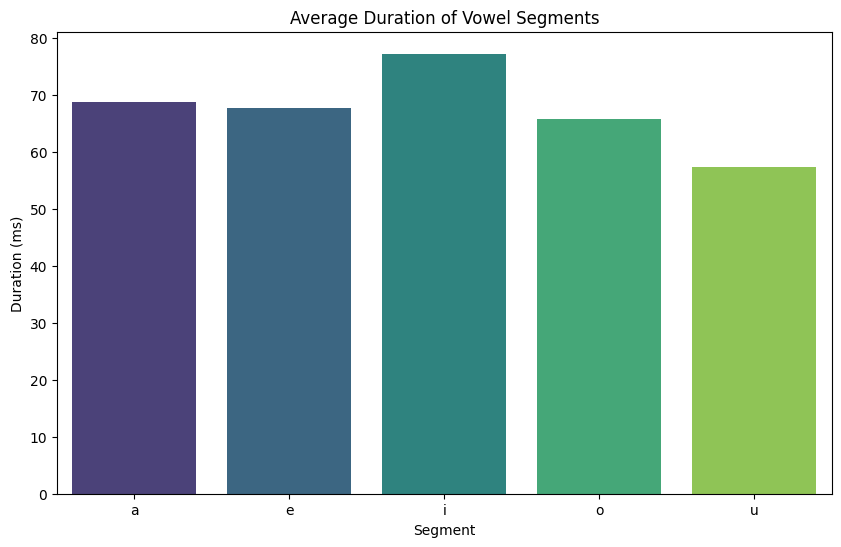

In [11]:
# Plotting average duration of vowel segments using Seaborn

# Set the figure size for the plot
plt.figure(figsize=(10, 6))

# Create a bar plot with Seaborn
# x-axis represents 'segment', y-axis represents 'dur' (duration), using 'viridis' color palette
sns.barplot(x='segment', y='dur', data=vowel_durations, palette='viridis')

# Label the x-axis
plt.xlabel('Segment')

# Label the y-axis
plt.ylabel('Duration (ms)')

# Set the title of the plot
plt.title('Average Duration of Vowel Segments')

# Display the plot
plt.show()


In [12]:
# Define lists of segments for different types
vowel_segments = 'a A aj AJ aw AW e E ej EJ ew EW i I ja JA je JE jo JO ju JU o O oj OJ u U uj UJ wa WA waj WAJ we WE wi WI wo WO'.split()
semivowel_segments = 'j J w W'.split()
semivowel_segments_2 = 'b C d g k p t m n N f s h S B D G l r R Y'.split()

# Mutate 'type' column based on segment categories
df['type'] = np.select(
    [
        df['segment'].isin(vowel_segments),          # Condition for vowel segments
        df['segment'].isin(semivowel_segments),      # Condition for first set of semivowel segments
        df['segment'].isin(semivowel_segments_2)     # Condition for second set of semivowel segments
    ],
    [
        'vowel',       # Value to assign for vowel segments
        'semivowel',   # Value to assign for first set of semivowel segments
        'semivowel'    # Value to assign for second set of semivowel segments (assuming correct)
    ],
    default='numeric'   # Default value for segments not in any of the lists
)

# Display the DataFrame with the new 'type' column
df


,speaker,previous,segment,following,onset,offset,dur,previousWord,word,followingWord,...,followingText,textOnset,textOffset,textDur,position,wordposition,segments,previous_segs,following_segs,type
0,CA1HA_87,,i,a,299.63,300.05,0.42,,y,además,...,que es muy reconocida en ingeniería civil,299.63,303.852652,4.222652,both,initial,i,,a,vowel
1,CA1HA_87,i,a,ð,300.05,300.12,0.07,y,además,además,...,que es muy reconocida en ingeniería civil,299.63,303.852652,4.222652,initial,medial,a,i,ð,vowel
2,CA1HA_87,a,ð,e,300.12,300.20,0.08,y,además,además,...,que es muy reconocida en ingeniería civil,299.63,303.852652,4.222652,medial,medial,ð,a,e,numeric
3,CA1HA_87,ð,e,m,300.20,300.26,0.06,y,además,además,...,que es muy reconocida en ingeniería civil,299.63,303.852652,4.222652,medial,medial,e,ð,m,vowel
4,CA1HA_87,e,m,a,300.26,300.33,0.07,y,además,además,...,que es muy reconocida en ingeniería civil,299.63,303.852652,4.222652,medial,medial,m,e,a,semivowel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5648,CA1HA_87,s,i,n,895.55,895.58,0.03,ir,sin,que,...,,892.90,896.140000,3.240000,medial,medial,i,s,n,vowel
5649,CA1HA_87,i,n,e,895.58,895.67,0.09,ir,sin,que,...,,892.90,896.140000,3.240000,final,medial,n,i,e,semivowel
5650,CA1HA_87,n,e,ʝ,895.67,895.78,0.11,sin,ella,que,...,,892.90,896.140000,3.240000,initial,medial,e,n,ʝ,vowel
5651,CA1HA_87,e,ʝ,a,895.78,895.85,0.07,sin,ella,que,...,,892.90,896.140000,3.240000,medial,medial,ʝ,e,a,numeric


In [13]:
# Define segment categories for different manners of articulation
stop_segments = 'b C d g k p t'.split()
nasal_segments = 'm n N'.split()
fricative_segments = 'f s h S B D G'.split()
liquid_segments = 'l r R Y'.split()
vowel_segments = 'a A e E i I o O u U'.split()
semivowel_segments = 'j J w W'.split()
blank_segments = ['', ' ']

# Define segments based on voicing
voiced_segments = 'a A aj AJ aw AW b d e E ej EJ ew EW g i I ja JA je JE jo JO ju JU l m n N o O oj OJ r R u U uj UJ wa WA waj WAJ we WE wi WI wo WO Y B D G J j w W'.split()
voiceless_segments = 'C f k p s S t h'.split()

# Function to map a segment to its manner category
def map_manner(segment, manner_dict):
    for key, value in manner_dict.items():
        if segment in value:
            return key
    return 'numeric'  # Return 'numeric' if the segment does not match any category

# Dictionary for manner of articulation categories
manner_dict = {
    'stop': stop_segments,
    'nasal': nasal_segments,
    'fricative': fricative_segments,
    'liquid': liquid_segments,
    'vowel': vowel_segments,
    'semivowel': semivowel_segments,
    'blank': blank_segments
}

# Dictionary for major manner categories
manner_maj_dict = {
    'obstruent': stop_segments + fricative_segments,
    'sonorant': nasal_segments + liquid_segments,
    'vowel': vowel_segments,
    'semivowel': semivowel_segments,
    'blank': blank_segments
}

# Dictionary for place of articulation categories
place_maj_dict = {
    'labial': 'b m p f B'.split(),
    'coronal': 'C d l n N r R s S t Y D'.split(),
    'dorsal': 'g k h G'.split(),
    'vowel': vowel_segments,
    'semivowel': semivowel_segments,
    'blank': blank_segments
}

# Dictionary for voicing categories
voicing_dict = {
    'voiced': voiced_segments,
    'voiceless': voiceless_segments,
    'blank': blank_segments
}

# Output the dictionaries for reference
manner_dict, manner_maj_dict, place_maj_dict, voicing_dict


({'stop': ['b', 'C', 'd', 'g', 'k', 'p', 't'],
  'nasal': ['m', 'n', 'N'],
  'fricative': ['f', 's', 'h', 'S', 'B', 'D', 'G'],
  'liquid': ['l', 'r', 'R', 'Y'],
  'vowel': ['a', 'A', 'e', 'E', 'i', 'I', 'o', 'O', 'u', 'U'],
  'semivowel': ['j', 'J', 'w', 'W'],
  'blank': ['', ' ']},
 {'obstruent': ['b',
   'C',
   'd',
   'g',
   'k',
   'p',
   't',
   'f',
   's',
   'h',
   'S',
   'B',
   'D',
   'G'],
  'sonorant': ['m', 'n', 'N', 'l', 'r', 'R', 'Y'],
  'vowel': ['a', 'A', 'e', 'E', 'i', 'I', 'o', 'O', 'u', 'U'],
  'semivowel': ['j', 'J', 'w', 'W'],
  'blank': ['', ' ']},
 {'labial': ['b', 'm', 'p', 'f', 'B'],
  'coronal': ['C', 'd', 'l', 'n', 'N', 'r', 'R', 's', 'S', 't', 'Y', 'D'],
  'dorsal': ['g', 'k', 'h', 'G'],
  'vowel': ['a', 'A', 'e', 'E', 'i', 'I', 'o', 'O', 'u', 'U'],
  'semivowel': ['j', 'J', 'w', 'W'],
  'blank': ['', ' ']},
 {'voiced': ['a',
   'A',
   'aj',
   'AJ',
   'aw',
   'AW',
   'b',
   'd',
   'e',
   'E',
   'ej',
   'EJ',
   'ew',
   'EW',
   'g',
   'i',

In [14]:
# Apply mappings to the DataFrame to determine the manner of articulation for previous, current, and following segments

# Apply the manner_dict to classify the manner of articulation for 'previous', 'segment', and 'following'
df['prevManner'] = df['previous'].apply(map_manner, manner_dict=manner_dict)
df['manner'] = df['segment'].apply(map_manner, manner_dict=manner_dict)
df['follManner'] = df['following'].apply(map_manner, manner_dict=manner_dict)

# Apply the manner_maj_dict to classify the major manner categories for 'previous', 'segment', and 'following'
df['prevMannerMaj'] = df['previous'].apply(map_manner, manner_dict=manner_maj_dict)
df['mannerMaj'] = df['segment'].apply(map_manner, manner_dict=manner_maj_dict)
df['follMannerMaj'] = df['following'].apply(map_manner, manner_dict=manner_maj_dict)

# Apply the place_maj_dict to classify the major place categories for 'previous', 'segment', and 'following'
df['prevPlaceMaj'] = df['previous'].apply(map_manner, manner_dict=place_maj_dict)
df['placeMaj'] = df['segment'].apply(map_manner, manner_dict=place_maj_dict)
df['follPlaceMaj'] = df['following'].apply(map_manner, manner_dict=place_maj_dict)

# Apply the voicing_dict to classify the voicing for 'previous', 'segment', and 'following'
df['prevVoicing'] = df['previous'].apply(map_manner, manner_dict=voicing_dict)
df['voicing'] = df['segment'].apply(map_manner, manner_dict=voicing_dict)
df['follVoicing'] = df['following'].apply(map_manner, manner_dict=voicing_dict)

# Calculate the midpoint of the segment and the word
df['mid'] = df['onset'] + ((df['offset'] - df['onset']) / 2)
df['wordMid'] = df['wordOnset'] + ((df['wordOffset'] - df['wordOnset']) / 2)

# Save the DataFrame with the new columns to a CSV file
df.to_csv('./File_Output/ProcessedPhonologicalContexts.csv', index=False)

# Display the updated DataFrame
df


,speaker,previous,segment,following,onset,offset,dur,previousWord,word,followingWord,...,mannerMaj,follMannerMaj,prevPlaceMaj,placeMaj,follPlaceMaj,prevVoicing,voicing,follVoicing,mid,wordMid
0,CA1HA_87,,i,a,299.63,300.05,0.42,,y,además,...,vowel,vowel,blank,vowel,vowel,blank,voiced,voiced,299.840,299.840
1,CA1HA_87,i,a,ð,300.05,300.12,0.07,y,además,además,...,vowel,numeric,vowel,vowel,numeric,voiced,voiced,numeric,300.085,300.240
2,CA1HA_87,a,ð,e,300.12,300.20,0.08,y,además,además,...,numeric,vowel,vowel,numeric,vowel,voiced,numeric,voiced,300.160,300.240
3,CA1HA_87,ð,e,m,300.20,300.26,0.06,y,además,además,...,vowel,sonorant,numeric,vowel,labial,numeric,voiced,voiced,300.230,300.240
4,CA1HA_87,e,m,a,300.26,300.33,0.07,y,además,además,...,sonorant,vowel,vowel,labial,vowel,voiced,voiced,voiced,300.295,300.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5648,CA1HA_87,s,i,n,895.55,895.58,0.03,ir,sin,que,...,vowel,sonorant,coronal,vowel,coronal,voiceless,voiced,voiced,895.565,895.535
5649,CA1HA_87,i,n,e,895.58,895.67,0.09,ir,sin,que,...,sonorant,vowel,vowel,coronal,vowel,voiced,voiced,voiced,895.625,895.535
5650,CA1HA_87,n,e,ʝ,895.67,895.78,0.11,sin,ella,que,...,vowel,numeric,coronal,vowel,numeric,voiced,voiced,numeric,895.725,895.800
5651,CA1HA_87,e,ʝ,a,895.78,895.85,0.07,sin,ella,que,...,numeric,vowel,vowel,numeric,vowel,voiced,numeric,voiced,895.815,895.800


In [15]:
# Calculate 'time' as the midpoint of the segment based on 'onset' and 'offset'
dat['time'] = dat['onset'] + ((dat['offset'] - dat['onset']) / 2)

# Create a 'row_index' column with a sequence of integers starting from 1
dat['row_index'] = np.arange(1, len(dat) + 1)

# Select specific columns and create a new DataFrame for appending additional features
dat_append = dat[['speaker', 'time', 'row_index']].copy()

# Add columns for formant, pitch, intensity, and MFCC features with default values set to 0
dat_append = dat_append.assign(
    formant_1=0, 
    formant_2=0, 
    formant_3=0, 
    pitchValue=0, 
    intensityValue=0,
    mfcc_1=0,
    mfcc_2=0,
    mfcc_3=0,
    mfcc_4=0,
    mfcc_5=0,
    mfcc_6=0,
    mfcc_7=0,
    mfcc_8=0,
    mfcc_9=0,
    mfcc_10=0,
    mfcc_11=0,
    mfcc_12=0
)

# Save the original DataFrame with added phonological contexts to a CSV file
dat.to_csv('./File_Output/ProcessedPhonologicalContexts_preped.csv', index=False)

# Save the new DataFrame with additional feature columns to a separate CSV file
dat_append.to_csv('./File_Output/ProcessedPhonologicalContexts_append.csv', index=False)

# Display the updated DataFrames
dat, dat_append


(       speaker previous segment following   onset  offset   dur previousWord  \
 0     CA1HA_87                i         a  299.63  300.05  0.42                
 1     CA1HA_87        i       a         ð  300.05  300.12  0.07            y   
 2     CA1HA_87        a       ð         e  300.12  300.20  0.08            y   
 3     CA1HA_87        ð       e         m  300.20  300.26  0.06            y   
 4     CA1HA_87        e       m         a  300.26  300.33  0.07            y   
 ...        ...      ...     ...       ...     ...     ...   ...          ...   
 5648  CA1HA_87        s       i         n  895.55  895.58  0.03           ir   
 5649  CA1HA_87        i       n         e  895.58  895.67  0.09           ir   
 5650  CA1HA_87        n       e         ʝ  895.67  895.78  0.11          sin   
 5651  CA1HA_87        e       ʝ         a  895.78  895.85  0.07          sin   
 5652  CA1HA_87        ʝ       a            895.85  895.93  0.08          sin   
 
         word followingWor